<a href="https://colab.research.google.com/github/w20230622w-ship-it/NKUST_AI_CUP_II/blob/main/%E3%80%8CAI_CUP_2025_aortic_valve_object_detection_train_and_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.12.12


查看GPU資訊(運行時間<1秒) image.png

In [ ]:
!nvidia-smi

Fri Dec 19 02:47:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   31C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

確保不會出現編碼錯誤(運行時間<1秒) image.png

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

下載YOLOv12套件(運行時間12秒) image.png

In [ ]:
!pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
Setup complete ✅ (12 CPUs, 53.0 GB RAM, 38.5/235.7 GB disk)


.yaml 檔內容

.yaml 範例:https://drive.google.com/file/d/13hSr3sa2wOZqlvY1RAwr2msCfTdkfjMe/view?usp=sharing

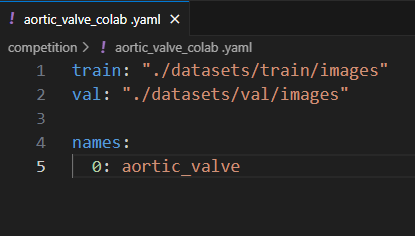



In [ ]:
#下載資料集
import gdown
import os
import shutil

#下載training_image.zip
gdown.download("https://drive.google.com/uc?export=download&id=11Aigs-YlHUr2IJHZTb1_CORvuVrmafEe","/content/training_image.zip")
#下載training_label.zip
gdown.download("https://drive.google.com/uc?export=download&id=1JPAKROHu12B5520WF7rRV5J3Sd48eE3Y","/content/training_label.zip")
#下載訓練aortic_valve_colab.yaml
gdown.download("https://drive.google.com/uc?export=download&id=1jwP6DJWF2gp0FQ-13eXOFzrHfLUncud5","/content/aortic_valve_colab.yaml")

Downloading...
From (original): https://drive.google.com/uc?export=download&id=11Aigs-YlHUr2IJHZTb1_CORvuVrmafEe
From (redirected): https://drive.google.com/uc?export=download&id=11Aigs-YlHUr2IJHZTb1_CORvuVrmafEe&confirm=t&uuid=84abbe3d-ff4f-45c8-9ca5-cdfb4f91bc91
To: /content/training_image.zip
100%|██████████| 1.83G/1.83G [00:26<00:00, 68.5MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1JPAKROHu12B5520WF7rRV5J3Sd48eE3Y
To: /content/training_label.zip
100%|██████████| 659k/659k [00:00<00:00, 6.97MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1jwP6DJWF2gp0FQ-13eXOFzrHfLUncud5
To: /content/aortic_valve_colab.yaml
100%|██████████| 91.0/91.0 [00:00<00:00, 223kB/s]


'/content/aortic_valve_colab.yaml'

In [ ]:
#移動檔案
import random
def find_patient_root(root):
    """往下找，直到找到含有 patientXXXX 的資料夾"""
    for dirpath, dirnames, filenames in os.walk(root):
        if any(d.startswith("patient") for d in dirnames):
            return dirpath
    return root  # fallback

# 解壓縮到固定資料夾
if not os.path.isdir("./training_image") and os.path.exists("training_image.zip"):
    os.makedirs("./training_image", exist_ok=True)
    !unzip -q training_image.zip -d ./training_image

if not os.path.isdir("./training_label") and os.path.exists("training_label.zip"):
    os.makedirs("./training_label", exist_ok=True)
    !unzip -q training_label.zip -d ./training_label

IMG_ROOT = find_patient_root("./training_image")
LBL_ROOT = find_patient_root("./training_label")

print("IMG_ROOT =", IMG_ROOT)
print("LBL_ROOT =", LBL_ROOT)

# 建立輸出資料夾
os.makedirs("./datasets/train/images", exist_ok=True)
os.makedirs("./datasets/train/labels", exist_ok=True)
os.makedirs("./datasets/val/images", exist_ok=True)
os.makedirs("./datasets/val/labels", exist_ok=True)

def move_data_with_ratio(start, end, split, negative_ratio=0.1):


    #確保範圍正確
    if start > end:
        start, end = end, start

    # 建立暫存清單
    positive_samples = [] # 存放 (img_path, lbl_path, filename)
    negative_samples = [] # 存放 (img_path, filename)

    print(f"正在掃描 Patient {start:04d} 到 {end:04d} 的檔案...")

    # ---收集所有檔案名單 ---
    for i in range(start, end + 1):
        patient = f"patient{i:04d}"
        img_dir = os.path.join(IMG_ROOT, patient)
        lbl_dir = os.path.join(LBL_ROOT, patient)

        if not os.path.isdir(img_dir):
            continue

        for fname in os.listdir(img_dir):
            if not fname.endswith(".png"):
                continue

            img_path = os.path.join(img_dir, fname)
            base_name, _ = os.path.splitext(fname)
            label_name = base_name + ".txt"
            label_path = os.path.join(lbl_dir, label_name)

            # 判斷是否有標註檔
            if os.path.exists(label_path):
                positive_samples.append((img_path, label_path, fname, label_name))
            else:
                negative_samples.append((img_path, fname, label_name))

    # ---計算要抽取的負樣本數量 ---
    num_pos = len(positive_samples)
    target_neg = int(num_pos * negative_ratio)

    # 確保不會超過實際擁有的負樣本總數
    num_neg_to_take = min(target_neg, len(negative_samples))

    print(f"[{split}] 統計結果:")
    print(f"  - 有標註圖片 (Positive): {num_pos} 張")
    print(f"  - 無標註圖片 (Negative): 總共 {len(negative_samples)} 張")
    print(f"  - 設定比例 {negative_ratio}，將選取: {num_neg_to_take} 張無標註圖片加入")

    # --- 隨機抽樣 ---
    # 對無標註名單進行洗牌，然後切片取出前 N 個
    random.shuffle(negative_samples)
    selected_negatives = negative_samples[:num_neg_to_take]

    # --- 執行搬移 ---
    # 搬移有標註的 (全部搬)
    for img_src, lbl_src, fname, lbl_name in positive_samples:
        shutil.move(img_src, f"./datasets/{split}/images/{fname}")
        shutil.move(lbl_src, f"./datasets/{split}/labels/{lbl_name}")

    #搬移無標註的 (只搬被選中的)，並建立空 txt
    for img_src, fname, lbl_name in selected_negatives:
        shutil.move(img_src, f"./datasets/{split}/images/{fname}")

        # 建立空的標註檔
        target_lbl_path = f"./datasets/{split}/labels/{lbl_name}"
        with open(target_lbl_path, 'w') as f:
            pass


#訓練集
move_data_with_ratio(1, 40, "train", negative_ratio=0.8)
#驗證集
move_data_with_ratio(40, 50, "val", negative_ratio=0.5)

print("所有檔案處理完成！")

IMG_ROOT = ./training_image/training_image
LBL_ROOT = ./training_label/training_label
正在掃描 Patient 0001 到 0040 的檔案...
[train] 統計結果:
  - 有標註圖片 (Positive): 2168 張
  - 無標註圖片 (Negative): 總共 11009 張
  - 設定比例 0.8，將選取: 1734 張無標註圖片加入
正在掃描 Patient 0040 到 0050 的檔案...
[val] 統計結果:
  - 有標註圖片 (Positive): 619 張
  - 無標註圖片 (Negative): 總共 3338 張
  - 設定比例 0.5，將選取: 309 張無標註圖片加入
所有檔案處理完成！


確認檔案是否成功移動 image.png

如果資料數量符合下圖數量代表移動成功

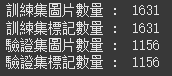

In [ ]:
!ls

aortic_valve_colab.yaml  training_image      training_label
datasets		 training_image.zip  training_label.zip


In [ ]:
print('訓練集圖片數量 : ',len(os.listdir("./datasets/train/images")))
print('訓練集標記數量 : ',len(os.listdir("./datasets/train/labels")))
print('驗證集圖片數量 : ',len(os.listdir("./datasets/val/images")))
print('驗證集標記數量 : ',len(os.listdir("./datasets/val/labels")))

訓練集圖片數量 :  3902
訓練集標記數量 :  3902
驗證集圖片數量 :  928
驗證集標記數量 :  928


#### 3. 訓練模型(運行時間約15分鐘)

執行後依序有Epoch在跑代表成功

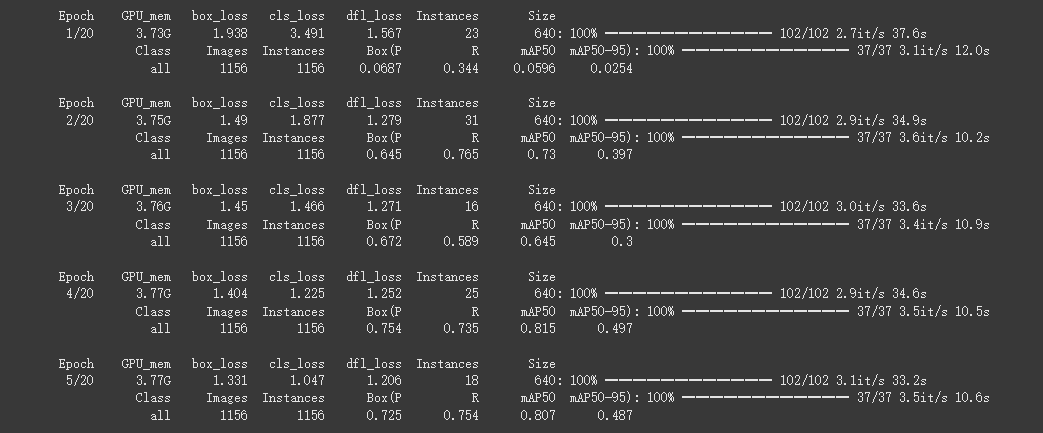

In [ ]:
from ultralytics import YOLO

model = YOLO('yolo12m.pt') #初次訓練使用YOLO官方的預訓練模型，如要使用自己的模型訓練可以將'yolo12n.pt'替換掉
results = model.train(
    data="./aortic_valve_colab.yaml",
    epochs=50,
    batch=16,
    imgsz=640,
    device=0,
    optimizer="AdamW",
    lr0=0.0001,


    # Loss Gains
    box=8.0,
    cls=0.5,
    dfl=2.5,

    # Augmentations
    hsv_v=0.4,
    degrees=5.0,
    translate=0.05,
    scale=0.2,
    mosaic=1.0,
    close_mosaic=10
)
save_dir = results.save_dir
csv_path = os.path.join(save_dir, 'results.csv')
print(f"\n訓練完成！數據已儲存於: {csv_path}")

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=8.0, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./aortic_valve_colab.yaml, degrees=5.0, deterministic=True, device=0, dfl=2.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0,

訓練完左方檔案會有run資料夾，此份Colab主要目標是得到best.pt用於下一份Colab進行預測image.png

(!!如果有重複訓練**請下載最後成功**的train編號資料夾)

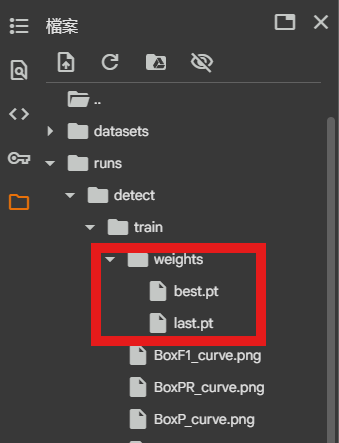

#### 4. 壓縮並下載訓練完的模型

確認下方進度條消失才有下載成功 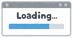

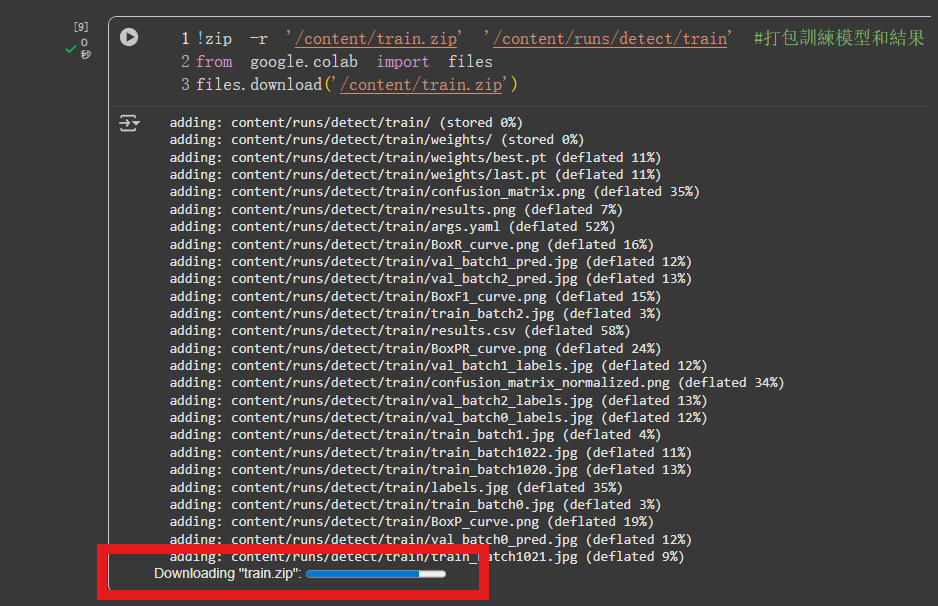

In [ ]:
!zip -r '/content/train.zip' '/content/runs/detect/train' #打包訓練模型和結果
from google.colab import files
files.download('/content/train.zip')

  adding: content/runs/detect/train/ (stored 0%)
  adding: content/runs/detect/train/train_batch9762.jpg (deflated 6%)
  adding: content/runs/detect/train/labels.jpg (deflated 35%)
  adding: content/runs/detect/train/train_batch9760.jpg (deflated 10%)
  adding: content/runs/detect/train/BoxF1_curve.png (deflated 17%)
  adding: content/runs/detect/train/val_batch1_labels.jpg (deflated 14%)
  adding: content/runs/detect/train/val_batch0_pred.jpg (deflated 13%)
  adding: content/runs/detect/train/val_batch2_labels.jpg (deflated 12%)
  adding: content/runs/detect/train/train_batch1.jpg (deflated 3%)
  adding: content/runs/detect/train/BoxR_curve.png (deflated 16%)
  adding: content/runs/detect/train/train_batch2.jpg (deflated 2%)
  adding: content/runs/detect/train/val_batch0_labels.jpg (deflated 13%)
  adding: content/runs/detect/train/confusion_matrix.png (deflated 35%)
  adding: content/runs/detect/train/results.csv (deflated 60%)
  adding: content/runs/detect/train/results.png (deflate

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

也可以右鍵直接下載best.pt和last.pt image.png

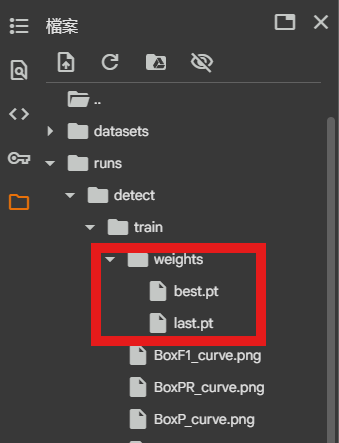

透過上面方法更改下方程式的網址(執行時間<1分鐘) image.png


 *請自行上傳雲端替換成自己的連結，此範例連結雖然與最初競賽資料集相同，但不保證會更新且隨時有可能會刪除!!!

In [ ]:
#下載測試資料集
import gdown
import os
!mkdir ./datasets/test
gdown.download("https://drive.google.com/uc?export=download&id=18xqJM7BBOoEKxVBr91G6Kxypmds7GqBE","/content/datasets/testing.zip")
!unzip '/content/datasets/testing' -d '/content/datasets/test/tmp'

Downloading...
From (original): https://drive.google.com/uc?export=download&id=18xqJM7BBOoEKxVBr91G6Kxypmds7GqBE
From (redirected): https://drive.google.com/uc?export=download&id=18xqJM7BBOoEKxVBr91G6Kxypmds7GqBE&confirm=t&uuid=5cb0d166-90a1-4a00-99fe-bf9ae0996f92
To: /content/datasets/testing.zip
100%|██████████| 1.83G/1.83G [00:18<00:00, 97.2MB/s]


串流輸出內容已截斷至最後 5000 行。
  inflating: /content/datasets/test/tmp/testing_image/patient0086/patient0086_0078.png  
  inflating: /content/datasets/test/tmp/testing_image/patient0086/patient0086_0079.png  
  inflating: /content/datasets/test/tmp/testing_image/patient0086/patient0086_0080.png  
  inflating: /content/datasets/test/tmp/testing_image/patient0086/patient0086_0081.png  
  inflating: /content/datasets/test/tmp/testing_image/patient0086/patient0086_0082.png  
  inflating: /content/datasets/test/tmp/testing_image/patient0086/patient0086_0083.png  
  inflating: /content/datasets/test/tmp/testing_image/patient0086/patient0086_0084.png  
  inflating: /content/datasets/test/tmp/testing_image/patient0086/patient0086_0085.png  
  inflating: /content/datasets/test/tmp/testing_image/patient0086/patient0086_0086.png  
  inflating: /content/datasets/test/tmp/testing_image/patient0086/patient0086_0087.png  
  inflating: /content/datasets/test/tmp/testing_image/patient0086/patient0086_0088.png  


因為本競賽Testing資料集有16620張圖片，如果全部一起預測Colab的RAM會不足，所以將Testing圖片分成兩次做預測

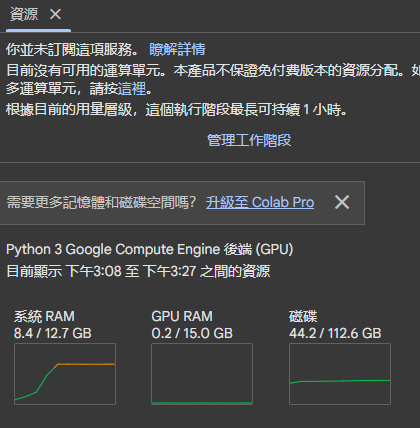

移動圖片位置(透過下方程式)


一半的圖片移至imges1資料夾，另一半移至imges2資料夾

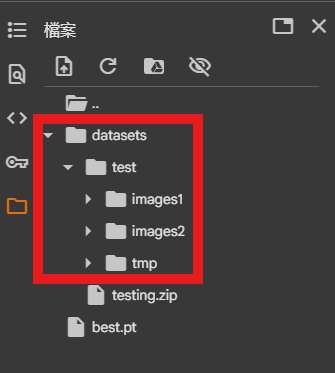

In [ ]:
import os
import shutil

base_root = "/content/datasets/test/tmp"
dst_root1 = "/content/datasets/test/images1"
dst_root2 = "/content/datasets/test/images2"

os.makedirs(dst_root1, exist_ok=True)
os.makedirs(dst_root2, exist_ok=True)

# 自動找到第一個「直屬子資料夾含 patient*」的目錄
patient_root = base_root
for dirpath, dirnames, _ in os.walk(base_root):
    if any(d.lower().startswith("patient") for d in dirnames):
        patient_root = dirpath
        break

# 收集所有圖片路徑（只看直屬的 patient 資料夾）
all_files = []
for patient_folder in os.listdir(patient_root):
    patient_path = os.path.join(patient_root, patient_folder)
    if os.path.isdir(patient_path) and patient_folder.lower().startswith("patient"):
        for fname in os.listdir(patient_path):
            if fname.lower().endswith(".png"):
                all_files.append(os.path.join(patient_path, fname))

# 按名稱排序並對半移動
all_files.sort()
half = len(all_files) // 2

for f in all_files[:half]:
    shutil.move(f, os.path.join(dst_root1, os.path.basename(f)))

for f in all_files[half:]:
    shutil.move(f, os.path.join(dst_root2, os.path.basename(f)))

print(f"來源根目錄：{patient_root}")
print(f"完成移動！總共 {len(all_files)} 張，前半 {half} 張到 images1，後半 {len(all_files)-half} 張到 images2")


來源根目錄：/content/datasets/test/tmp/testing_image
完成移動！總共 16620 張，前半 8310 張到 images1，後半 8310 張到 images2


In [ ]:
print('測試集圖片數量 : ',len(os.listdir("./datasets/test/images1"))+len(os.listdir("./datasets/test/images2")))

測試集圖片數量 :  16620


#### 5. Predict

移動剛剛訓練完的模型路徑

In [ ]:
!mv /content/runs/detect/train/weights/best.pt /content/

mv: cannot stat '/content/runs/detect/train/weights/best.pt': No such file or directory


下載模型權重檔(此權重檔為baseline提供的模型，參賽者可替換成自行訓練的模型檔)

In [ ]:
#自行上傳權重檔請註解掉下方程式
gdown.download("https://drive.google.com/uc?export=download&id=1cyV2eWcJYJcvWnc56L_zp1Lky3p9Yign","/content/best.pt")

使用自行訓練模型可透過拖移方式上傳至Colab

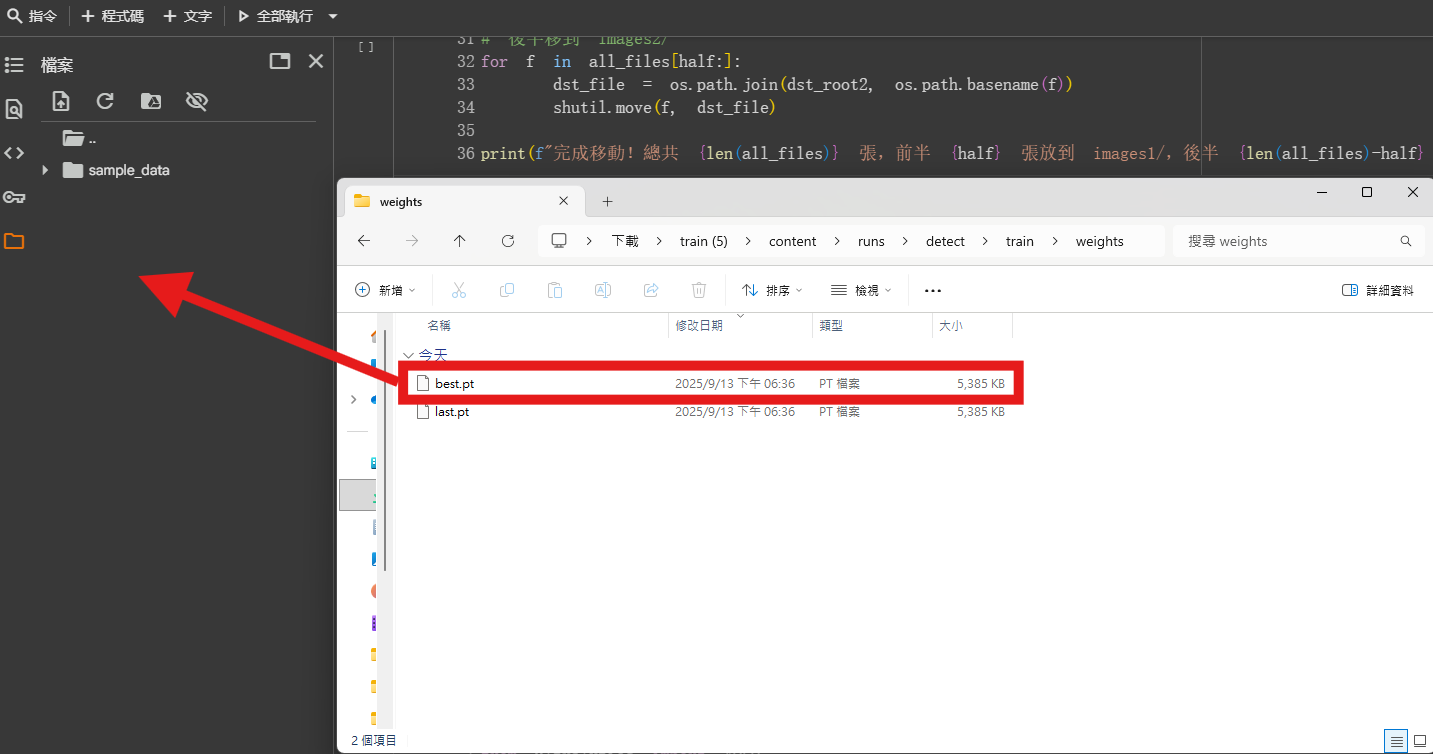

使用訓練過模型進行預測前半部分圖片(執行時間3分鐘)

In [ ]:
from ultralytics import YOLO

model = YOLO('/content/best.pt')
results = model.predict(source="./datasets/test/images1/",
              save=True,
              imgsz=640,
              device=0,
              conf=0.6
              )

串流輸出內容已截斷至最後 5000 行。
image 3313/8310 /content/datasets/test/images1/patient0060_0359.png: 640x640 (no detections), 14.7ms
image 3314/8310 /content/datasets/test/images1/patient0060_0360.png: 640x640 (no detections), 14.3ms
image 3315/8310 /content/datasets/test/images1/patient0060_0361.png: 640x640 (no detections), 14.6ms
image 3316/8310 /content/datasets/test/images1/patient0060_0362.png: 640x640 (no detections), 14.7ms
image 3317/8310 /content/datasets/test/images1/patient0060_0363.png: 640x640 (no detections), 14.6ms
image 3318/8310 /content/datasets/test/images1/patient0060_0364.png: 640x640 (no detections), 14.4ms
image 3319/8310 /content/datasets/test/images1/patient0060_0365.png: 640x640 (no detections), 14.5ms
image 3320/8310 /content/datasets/test/images1/patient0060_0366.png: 640x640 (no detections), 15.2ms
image 3321/8310 /content/datasets/test/images1/patient0060_0367.png: 640x640 (no detections), 15.4ms
image 3322/8310 /content/datasets/test/images1/patient0060_0368.png: 6

predict資料夾內**有圖片代表預測完成**


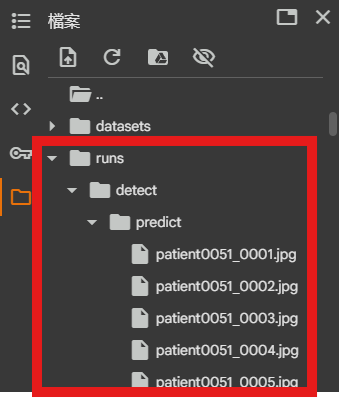

其中一張預測結果

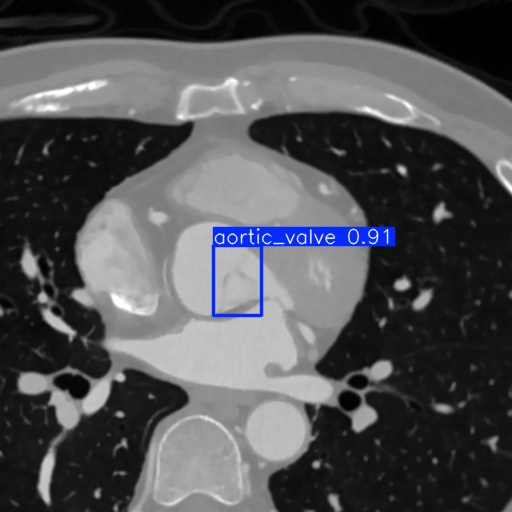

In [ ]:
from IPython.display import Image

Image(filename='/content/runs/detect/predict/patient0051_0260.jpg', height=640)

預測數量

In [ ]:
print(len(results))

8310


取得預測結果的資訊

想取得更多資訊可參考官方說明
https://docs.ultralytics.com/zh/modes/predict/#boxes

In [ ]:
print('預測類別 : ',results[260].boxes.cls[0].item())
print('預測信心分數 : ',results[260].boxes.conf[0].item())
print('預測框座標 : ',results[260].boxes.xyxy[0].tolist())

預測類別 :  0.0
預測信心分數 :  0.9116930365562439
預測框座標 :  [214.1801300048828, 245.458984375, 262.2455749511719, 314.355712890625]


將偵測框數值寫進.txt檔

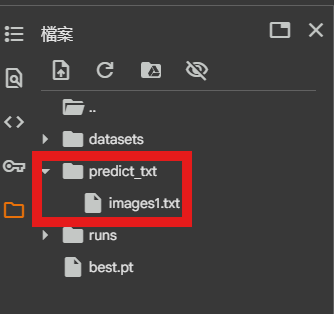

In [ ]:
!mkdir ./predict_txt/
output_file = open('./predict_txt/images1.txt', 'w')
for i in range(len(results)):
    # 取得圖片檔名（不含副檔名）
    filename = results[i].path.split('/')[-1].split('.png')[0]

    # 取得預測框數量
    boxes = results[i].boxes
    box_num = len(boxes.cls.tolist())

    # 如果有預測框
    if box_num > 0:
        for j in range(box_num):
            # 提取資訊
            label = int(boxes.cls[j].item())  # 類別
            conf = boxes.conf[j].item()       # 信心度
            x1, y1, x2, y2 = boxes.xyxy[j].tolist()  # 邊界框座標

            # 建立一行資料
            line = f"{filename} {label} {conf:.4f} {int(x1)} {int(y1)} {int(x2)} {int(y2)}\n"
            output_file.write(line)

# 關閉輸出檔案
output_file.close()


釋放記憶體

因為Colab RAM不會自動釋放，所以透過程式釋放


In [ ]:
import torch ,gc

# 刪除大型變數
del boxes,all_files,results
gc.collect()
torch.cuda.empty_cache()

預測後半圖片(執行時間3分鐘)

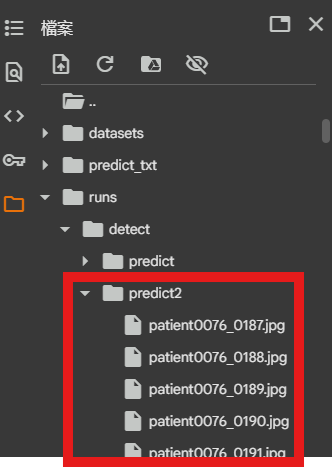

In [ ]:
from ultralytics import YOLO

model = YOLO('/content/best.pt')
results = model.predict(source="./datasets/test/images2/",
              save=True,
              imgsz=640,
              device=0,
              conf=0.6
              )

串流輸出內容已截斷至最後 5000 行。
image 3313/8310 /content/datasets/test/images2/patient0086_0051.png: 640x640 (no detections), 15.0ms
image 3314/8310 /content/datasets/test/images2/patient0086_0052.png: 640x640 (no detections), 15.8ms
image 3315/8310 /content/datasets/test/images2/patient0086_0053.png: 640x640 (no detections), 15.1ms
image 3316/8310 /content/datasets/test/images2/patient0086_0054.png: 640x640 (no detections), 15.0ms
image 3317/8310 /content/datasets/test/images2/patient0086_0055.png: 640x640 (no detections), 14.9ms
image 3318/8310 /content/datasets/test/images2/patient0086_0056.png: 640x640 (no detections), 15.9ms
image 3319/8310 /content/datasets/test/images2/patient0086_0057.png: 640x640 (no detections), 15.1ms
image 3320/8310 /content/datasets/test/images2/patient0086_0058.png: 640x640 (no detections), 14.8ms
image 3321/8310 /content/datasets/test/images2/patient0086_0059.png: 640x640 (no detections), 15.0ms
image 3322/8310 /content/datasets/test/images2/patient0086_0060.png: 6

將後半部分偵測框數值寫進.txt檔

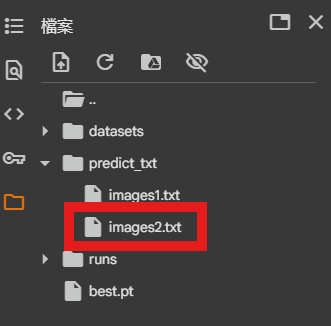

In [ ]:
output_file = open('./predict_txt/images2.txt', 'w')
for i in range(len(results)):
    # 取得圖片檔名（不含副檔名）
    filename = results[i].path.split('/')[-1].split('.png')[0]

    # 取得預測框數量
    boxes = results[i].boxes
    box_num = len(boxes.cls.tolist())

    # 如果有預測框
    if box_num > 0:
        for j in range(box_num):
            # 提取資訊
            label = int(boxes.cls[j].item())  # 類別
            conf = boxes.conf[j].item()       # 信心度
            x1, y1, x2, y2 = boxes.xyxy[j].tolist()  # 邊界框座標

            # 建立一行資料
            line = f"{filename} {label} {conf:.4f} {int(x1)} {int(y1)} {int(x2)} {int(y2)}\n"
            output_file.write(line)

# 關閉輸出檔案
output_file.close()


合併兩個.txt

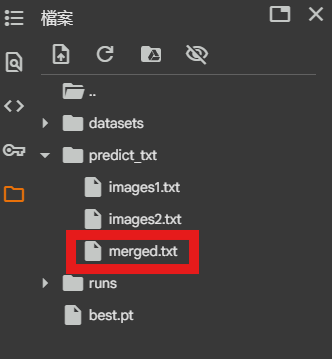

In [ ]:
file1 = "./predict_txt/images1.txt"
file2 = "./predict_txt/images2.txt"
output = "./predict_txt/merged.txt"

with open(output, "w", encoding="utf-8") as fout:
    for f in [file1, file2]:
        if os.path.exists(f):
            with open(f, "r", encoding="utf-8") as fin:
                fout.writelines(fin.readlines())

print(f"合併完成 -> {output}")


合併完成 -> ./predict_txt/merged.txt


In [ ]:
import os
import shutil
from google.colab import files

# 1. 設定來源資料夾
source_folders = {
    'run1': '/content/runs/detect/predict',   # 第一批 (例如 51-70)
    'run2': '/content/runs/detect/predict2'   # 第二批 (例如 71-100)
}

# 2. 設定合併後的目標資料夾
merged_folder = '/content/merged_predictions'

# 如果目標資料夾已存在，先刪除以確保乾淨
if os.path.exists(merged_folder):
    shutil.rmtree(merged_folder)
os.makedirs(merged_folder)

print(f"開始合併圖片到: {merged_folder} ...")

# 3. 開始搬移與更名
total_count = 0
for prefix, folder_path in source_folders.items():
    if os.path.exists(folder_path):
        files_in_folder = os.listdir(folder_path)
        print(f"正在處理 {folder_path} (共 {len(files_in_folder)} 個檔案)...")

        for filename in files_in_folder:
            # 只處理圖片
            if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                src_file = os.path.join(folder_path, filename)

                # 新檔名加上前綴 (run1_xxx.jpg) 以免檔名重複
                # 如果您確定檔名不重複且不想加前綴，可以改成: new_filename = filename
                new_filename = f"{prefix}_{filename}"
                dst_file = os.path.join(merged_folder, new_filename)

                shutil.copy(src_file, dst_file)
                total_count += 1
    else:
        print(f"警告: 找不到資料夾 {folder_path}")

print(f"合併完成！共 {total_count} 張圖片。")

# 4. 壓縮並下載
if total_count > 0:
    print("正在壓縮 ZIP 檔...")
    shutil.make_archive(merged_folder, 'zip', merged_folder)

    print("準備下載...")
    files.download(merged_folder + '.zip')
else:
    print("沒有找到任何圖片，無法下載。")

開始合併圖片到: /content/merged_predictions ...
正在處理 /content/runs/detect/predict (共 8310 個檔案)...
正在處理 /content/runs/detect/predict2 (共 8310 個檔案)...
合併完成！共 16620 張圖片。
正在壓縮 ZIP 檔...
準備下載...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

下載競賽提交txt  image.png

In [ ]:
from google.colab import files
files.download('/content/predict_txt/merged.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>